In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/src/

/content/drive/MyDrive/src


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt

from modules import *
from losses import *
from utils import random_binary_mask, get_synthetic_dataset, plot_synthetic_dataset,cosine_scheduler

In [ ]:
def clustering_accuracy(labels_true, labels_pred):
    from scipy.optimize import linear_sum_assignment
    from sklearn.metrics.cluster import _supervised

    labels_true, labels_pred = _supervised.check_clusterings(labels_true, labels_pred)
    value = _supervised.contingency_matrix(labels_true, labels_pred)
    [r, c] = linear_sum_assignment(-value)
    return value[r, c].sum() / len(labels_true)

In [ ]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
synthetic_X, synthetic_y = get_synthetic_dataset()
synthetic_X = (synthetic_X - synthetic_X.min()) / (synthetic_X.max() - synthetic_X.min())

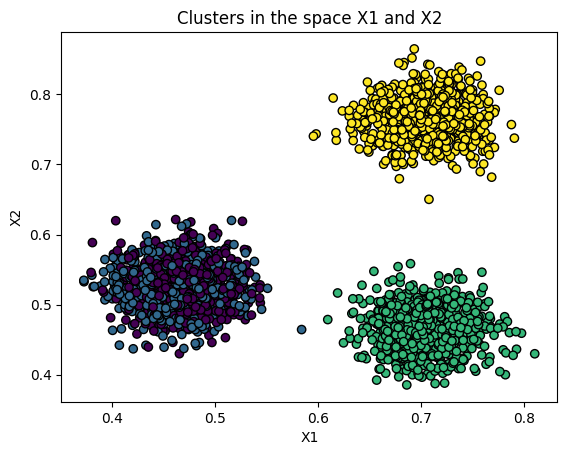

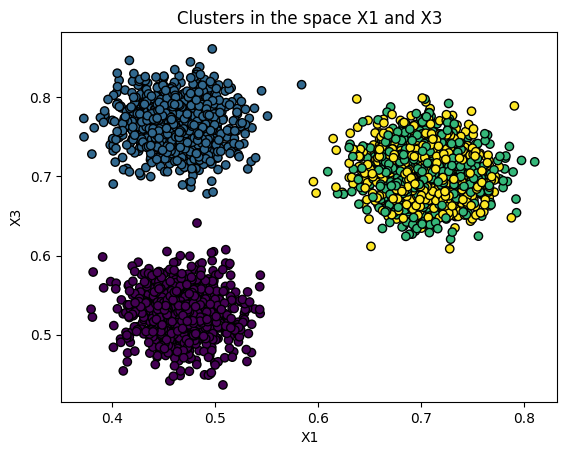

In [ ]:
plot_synthetic_dataset(synthetic_X, synthetic_y)

In [ ]:
from sklearn.cluster import KMeans

km = KMeans(4)

km.fit(synthetic_X)

yhat = km.predict(synthetic_X)

clustering_accuracy(yhat, synthetic_y)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1.0

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
synthetic_dataset = TensorDataset(synthetic_X, synthetic_y)

100%|██████████| 50/50 [00:07<00:00,  6.82it/s]


AE Training finished!


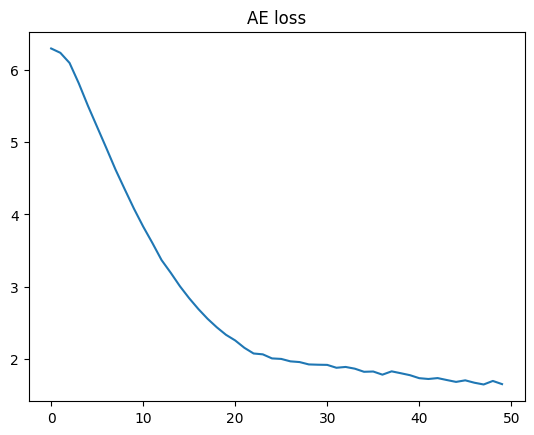

In [ ]:
synthetic_layer_dims = [13, 10, 8]

BATCH_SIZE = 800
synthetic_dataloader = DataLoader(synthetic_dataset, batch_size=BATCH_SIZE, shuffle=True)

ae = MLPAutoEncoder(synthetic_layer_dims)
criterion = SparseLoss(pretrain=True)

ae = ae.to(device)

LR = 1e-3
EPOCHS = 50

optimizer = optim.Adam(ae.parameters(), lr=LR)
losses = []

for epoch in tqdm(range(EPOCHS)):
    epoch_loss = 0.0

    for x, y in synthetic_dataloader:

        x = x.to(device)

        x_hat = ae(x)

        input_noise_mask = random_binary_mask(x.size(), x.device, type_mask="INPUT")
        x_input_noised_hat = ae(x * input_noise_mask)

        h = ae.encoder(x)
        h_noise = random_binary_mask(h.size(), h.device, type_mask="LATENT")
        h = h * h_noise
        x_latent_noised_hat = ae.decoder(h)

        loss = criterion(x, x_hat, x_input_noised_hat, x_latent_noised_hat, local_gates_lmbd=10)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Save the average loss for the epoch
    avg_epoch_loss = epoch_loss / len(synthetic_dataloader)
    losses.append(avg_epoch_loss)

print('AE Training finished!')
plt.plot(losses)
plt.title("AE loss")
plt.show()

------------------------------
AE Pre-training
------------------------------


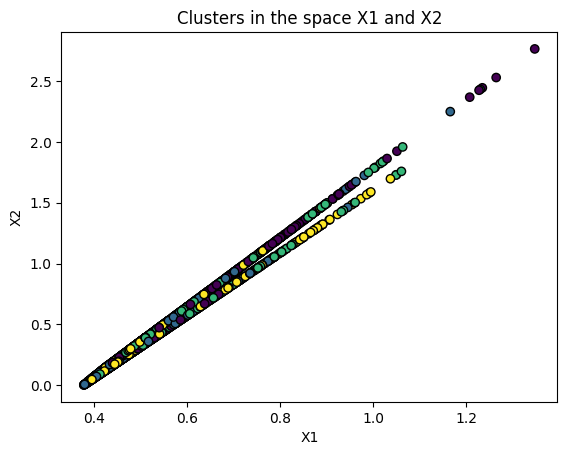

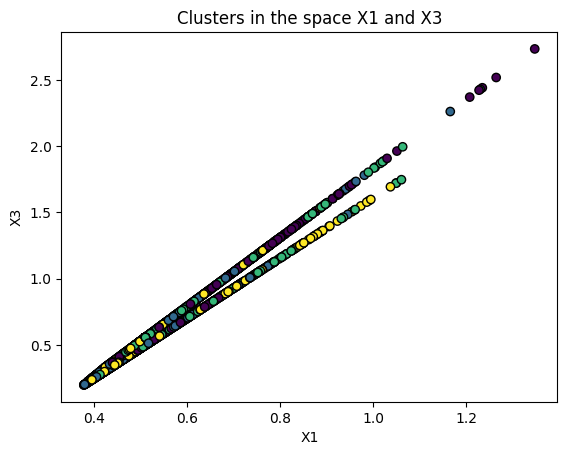

In [ ]:
with torch.no_grad():
    synthetic_X_hat = ae(synthetic_X.to(device))
    print("------------------------------")
    print("AE Pre-training")
    print("------------------------------")
    plot_synthetic_dataset(synthetic_X_hat.cpu().detach().numpy(), synthetic_y)

100%|██████████| 40/40 [00:08<00:00,  4.78it/s]


ALL Training finished!


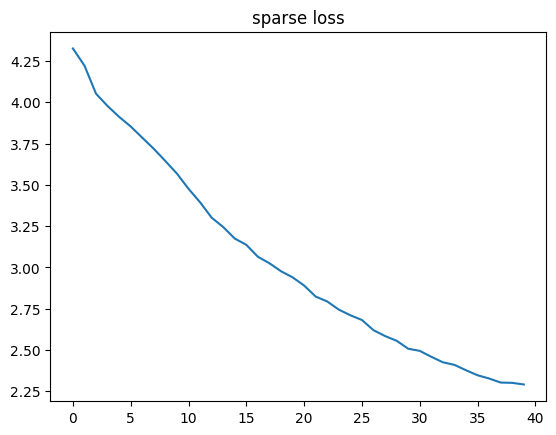

In [ ]:
gnn = GatingNN(13, 16)
gnn = gnn.to(device)

LR = 1e-3
EPOCHS = 40

optimizer = optim.Adam(list(gnn.parameters()) + list(ae.parameters()), lr=LR)
criterion = SparseLoss(pretrain=False)
losses = []

for epoch in tqdm(range(EPOCHS)):
    epoch_loss = 0.0
    lmbd = cosine_scheduler(epoch, EPOCHS, max_val=1)

    for x, y in synthetic_dataloader:

        x = x.to(device)

        x_z, z, u = gnn(x)
        x_hat = ae(x)
        x_z_hat = ae(x_z)

        input_noise_mask = random_binary_mask(x.size(), x.device, type_mask="INPUT")
        x_input_noised_hat = ae(x * input_noise_mask)

        h = ae.encoder(x)
        h_noise = random_binary_mask(h.size(), h.device, type_mask="LATENT")
        h = h * h_noise
        x_latent_noised_hat = ae.decoder(h)

        loss = criterion(x, x_hat, x_input_noised_hat, x_latent_noised_hat, x_z_hat, z, u, lmbd, local_gates_lmbd=10)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Save the average loss for the epoch
    avg_epoch_loss = epoch_loss / len(synthetic_dataloader)
    losses.append(avg_epoch_loss)

print('ALL Training finished!')
plt.plot(losses)
plt.title("sparse loss")
plt.show()

------------------------------
AE Fine-tuned , display for X
------------------------------


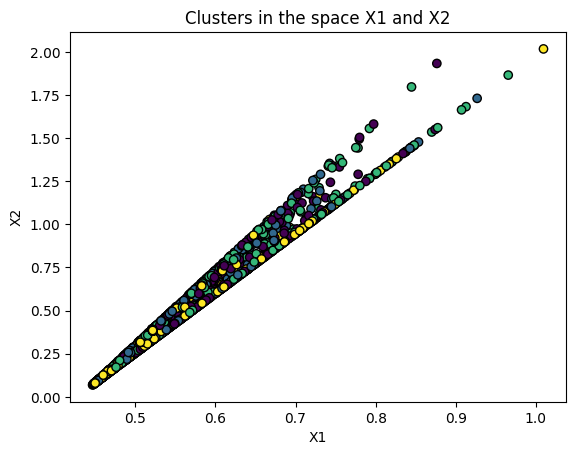

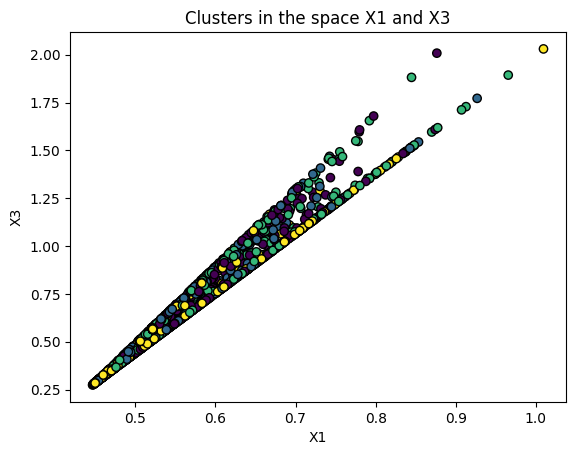

------------------------------
AE Fine-tuned , display for X_Z
------------------------------


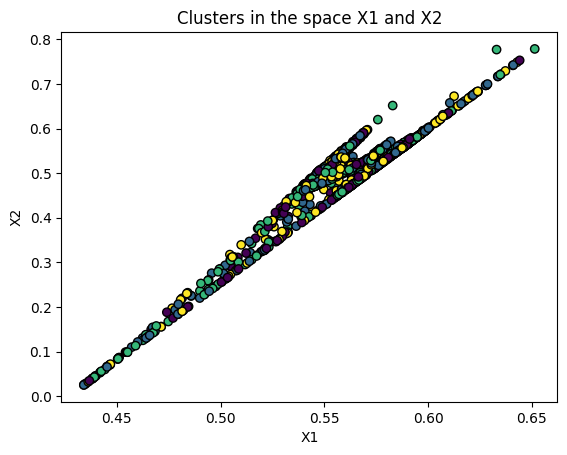

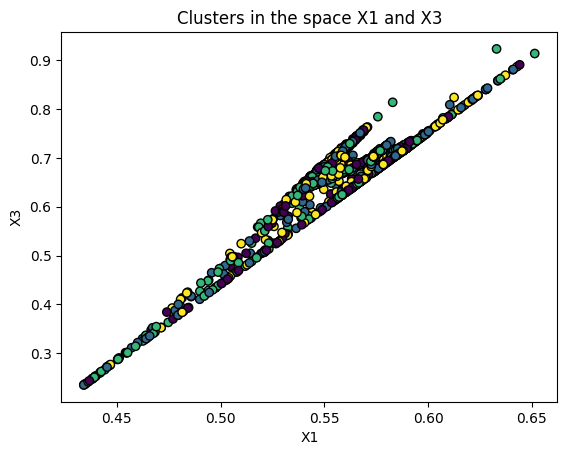

In [ ]:
with torch.no_grad():
    X = synthetic_X.to(device)
    X_Z ,z , _ = gnn(X)
    X_z_hat = ae(X_Z)
    X_hat = ae(X)

    print("------------------------------")
    print("AE Fine-tuned , display for X")
    print("------------------------------")
    plot_synthetic_dataset(X_hat.cpu().detach().numpy(), synthetic_y)

    print("------------------------------")
    print("AE Fine-tuned , display for X_Z")
    print("------------------------------")
    plot_synthetic_dataset(X_z_hat.cpu().detach().numpy(), synthetic_y)

In [ ]:
X = synthetic_X.to(device)
X_Z ,z , _ = gnn(X)

# # encode from X
# H_from_X = ae.encoder(X)

# encode from X_Z
H_from_X_Z = ae.encoder(X_Z)

In [ ]:
cluster_dataset = TensorDataset(X_Z, H_from_X_Z, synthetic_y)

BATCH_SIZE = 800
cluster_dataloader = DataLoader(cluster_dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 500/500 [01:41<00:00,  4.91it/s]


ClusterHead Training finished!


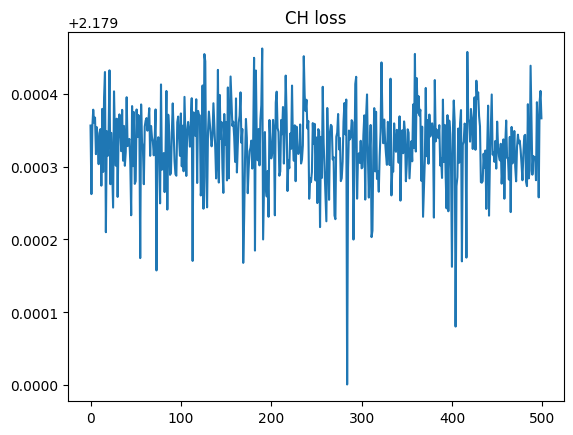

In [ ]:
clust = ClusteringNN(13, 8, 2, 4, tau=5)
criterion = ClusterLoss(4, pretrain=True)

clust = clust.to(device)

LR = 1e-2
EPOCHS = 500

optimizer = optim.Adam(clust.cluster_head.parameters(), lr=LR)
losses = []

for epoch in tqdm(range(EPOCHS)):
    epoch_loss = 0.0
    lmbd = cosine_scheduler(epoch, EPOCHS, max_val=1)

    for i, (x, h, y) in enumerate(cluster_dataloader):

        x = x.to(device)
        h = h.to(device)
        y = y.to(device)

        clust_logits, aux_logits, u_zg = clust(x, h)
        loss = criterion(h, clust_logits, aux_logits, u_zg, lmbd, gamma=4)

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        epoch_loss += loss.item()

    # Save the average loss for the epoch
    avg_epoch_loss = epoch_loss / len(cluster_dataloader)
    losses.append(avg_epoch_loss)

print('ClusterHead Training finished!')
plt.plot(losses)
plt.title("CH loss")
plt.show()

In [ ]:
with torch.no_grad():
    X = synthetic_X.to(device)
    X_Z ,z , _ = gnn(X)
    H = ae.encoder(X_Z)

    clust_logits, aux_logits, u_zg = clust(X_Z, H)
    yhat = clust_logits.argmax(dim=1).cpu()

    print(clustering_accuracy(yhat, synthetic_y))

0.25


100%|██████████| 500/500 [02:39<00:00,  3.13it/s]


ClusterHead Training finished!


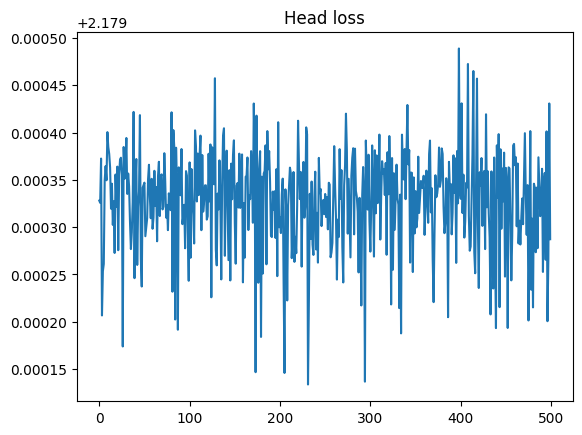

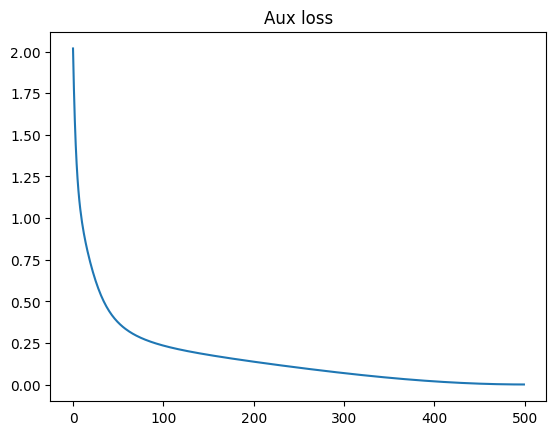

In [ ]:
criterion = ClusterLoss(4, pretrain=False)

LR_AUX = 1e-1
LR_ZG = 1e-1

EPOCHS = 500

optimizer_aux = optim.SGD(clust.aux_classifier.parameters(), lr=LR_AUX)
optimizer_ZG = optim.SGD(clust.global_gates.parameters(), lr=LR_ZG)

losses_head = []
losses_aux = []

for epoch in tqdm(range(EPOCHS)):
    epoch_loss_head = 0.0
    epoch_loss_aux = 0.0

    lmbd = cosine_scheduler(epoch, EPOCHS, max_val=1)

    for i, (x, h, y) in enumerate(cluster_dataloader):

        x = x.to(device)
        h = h.to(device)
        y = y.to(device)

        clust_logits, aux_logits, u_zg = clust(x, h)
        loss_head, loss_aux = criterion(h, clust_logits, aux_logits, u_zg, lmbd, gamma=4)

        optimizer.zero_grad()
        loss_head.backward(retain_graph=True)
        optimizer.step()

        optimizer_aux.zero_grad()
        optimizer_ZG.zero_grad()
        loss_aux.backward(retain_graph=True)
        optimizer_aux.step()
        optimizer_ZG.step()

        epoch_loss_head += loss_head.item()
        epoch_loss_aux += loss_aux.item()

    # Save the average loss for the epoch
    avg_epoch_loss_head = epoch_loss_head / len(cluster_dataloader)
    losses_head.append(avg_epoch_loss_head)

    avg_epoch_loss_aux = epoch_loss_aux / len(cluster_dataloader)
    losses_aux.append(avg_epoch_loss_aux)

print('ClusterHead Training finished!')

plt.plot(losses_head)
plt.title("Head loss")
plt.show()

plt.plot(losses_aux)
plt.title("Aux loss")
plt.show()

In [ ]:
with torch.no_grad():
    X = synthetic_X.to(device)
    X_Z ,z , _ = gnn(X)
    H = ae.encoder(X_Z)

    clust_logits, aux_logits, u_zg = clust(X_Z, H)
    yhat = clust_logits.argmax(dim=1).cpu()

    print(clustering_accuracy(yhat, synthetic_y))

0.25
